In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import pickle
import re
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import math
from scipy import interpolate

In [2]:
data_D1D2=pd.read_pickle('../data/dataset/D1D2_puregooddata_25032023.pkl')
data_D1=pd.read_pickle('../data/dataset/D1_puregooddata_25032023.pkl')

In [3]:
class pain_monitering_D1D2:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D1_time=[]
        self.D1_prediction=-1
        self.D1_confidence=-1
        self.D2_rating=[]
        self.D2_time=[]
        self.D2_prediction=-1
        self.D2_confidence=-1
    def __str__(self):
        print("participant: "+self.PID)
        print("Day 1 rating: "+str(len(self.D1_rating))+" sessions")
        print("Day 1 timing: "+str(len(self.D1_time))+" sessions")
        if self.D1_prediction!=-1 and self.D1_confidence!=-1:
            print("Day 1 prediction: "+ str(self.D1_prediction))
            print("Day 1 confidence: "+ str(self.D1_confidence))
        else:
            print("Invalid Day 1 prediction")
        if self.D2_rating!=[]:
            print("Day 2 rating: "+str(len(self.D2_rating))+" sessions")
            print("Day 2 timing: "+str(len(self.D2_time))+" sessions")
            if self.D2_prediction!=-1 and self.D2_confidence!=-1:
                print("Day 2 prediction: "+ str(self.D2_prediction))
                print("Day 2 confidence: "+ str(self.D2_confidence))
            else:
                print("Invalid Day 2 prediction")
        else:
            print("Not attending the second day")
        return ""
    def insert_rating_time_D1(self,rating_per_session,time_per_session):
        self.D1_rating.append(rating_per_session)
        self.D1_time.append(time_per_session)
    def insert_rating_time_D2(self,rating_per_session,time_per_session):
        self.D2_rating.append(rating_per_session)
        self.D2_time.append(time_per_session)
    def update_prediction_confidence_D1(self,pred,conf):
        self.D1_prediction=pred
        self.D1_confidence=conf
    def update_prediction_confidence_D2(self,pred,conf):
        self.D2_prediction=pred
        self.D2_confidence=conf

In [4]:
## D1 data
participant_list=[]
num_invalid_prediction_D1=0
num_invalid_prediction_D2=0
for i,pid in enumerate(data_D1['PID']):
    if i%3==0:
        partcipant=pain_monitering_D1D2(pid)
        partcipant.insert_rating_time_D1(data_D1['rating'][i],data_D1['time'][i])
        if ~np.isnan(data_D1['prediction'][i]) and ~np.isnan(data_D1['confidence'][i]):
            partcipant.update_prediction_confidence_D1(data_D1['prediction'][i],data_D1['confidence'][i])
        else:
            num_invalid_prediction_D1+=1
        participant_list.append(partcipant)
    else:
        participant_list[i//3].insert_rating_time_D1(data_D1['rating'][i],data_D1['time'][i])
print(str(len(participant_list))+" participants")
print("Day 1 invalid prediction: "+ str(num_invalid_prediction_D1))
## D2 data
pointer=-1
D2_part_num=0
for i,pid in enumerate(data_D1D2['PID']):
    if i%6==0:
        for part_j,part in enumerate(participant_list):
            if part.PID==pid:
                pointer=part_j
                D2_part_num+=1
                break
            else:
                pointer=-1
        if pointer==-1:
            print("error: "+pid)
        if ~(participant_list[pointer].D1_rating[i%6]==data_D1D2['rating'][i]).all():
            print("error: "+pid)
    elif i%6<3:
        if ~(participant_list[pointer].D1_rating[i%6]==data_D1D2['rating'][i]).all():
            print("error: "+pid)
    elif i%6==3:
        if ~np.isnan(data_D1D2['prediction'][i]) and ~np.isnan(data_D1D2['confidence'][i]):
            participant_list[pointer].update_prediction_confidence_D2(data_D1D2['prediction'][i],data_D1D2['confidence'][i])
        else:
            num_invalid_prediction_D2+=1
        participant_list[pointer].insert_rating_time_D2(data_D1D2['rating'][i],data_D1D2['time'][i])
    elif i%6>3:
        participant_list[pointer].insert_rating_time_D2(data_D1D2['rating'][i],data_D1D2['time'][i])
print(str(D2_part_num)+" participants attended Day 2")
print("Day 2 invalid prediction: "+ str(num_invalid_prediction_D2))


81 participants
Day 1 invalid prediction: 20
58 participants attended Day 2
Day 2 invalid prediction: 14


In [5]:
print(participant_list[3])

participant: 600606925db9c892b3939202
Day 1 rating: 3 sessions
Day 1 timing: 3 sessions
Day 1 prediction: 0.9452332200000001
Day 1 confidence: 7.55632779
Day 2 rating: 3 sessions
Day 2 timing: 3 sessions
Invalid Day 2 prediction



In [6]:
gap=10
length_limitation=10

In [7]:
def split_series(original_rating,original_timelist, gap_boundary):
    rating_split=[]
    timelist_split=[]
    start_label=0
    for time_j in range(len(original_timelist)-1):
        gap=original_timelist[time_j+1]-original_timelist[time_j]
        if gap > gap_boundary:
            time=original_timelist[start_label:time_j+1]
            if time[-1]-time[0]>=length_limitation:
                start_point=time[0]
                timelist_split.append([t-start_point for t in time])
                rating_split.append(original_rating[start_label:time_j+1])
            start_label=time_j+1
    rating_split.append(original_rating[start_label:len(original_timelist)])
    time=original_timelist[start_label:len(original_timelist)]
    start_point=time[0]
    timelist_split.append([t-start_point for t in time])
    return rating_split,timelist_split

In [8]:
part_after_split=[]
for part in participant_list:
    part_new=pain_monitering_D1D2(part.PID)
    part_new.update_prediction_confidence_D1(part.D1_prediction,part.D1_confidence)
    part_new.update_prediction_confidence_D2(part.D2_prediction,part.D2_confidence)
    for Session_i,timelist in enumerate(part.D1_time):
        rating_split,timelist_split=split_series(part.D1_rating[Session_i],timelist,gap)
        for split_i,rating in enumerate(rating_split):
            part_new.insert_rating_time_D1(rating,timelist_split[split_i])
    for Session_i,timelist in enumerate(part.D2_time):
        rating_split,timelist_split=split_series(part.D2_rating[Session_i],timelist,gap)
        for split_i,rating in enumerate(rating_split):
            part_new.insert_rating_time_D2(rating,timelist_split[split_i])
    part_after_split.append(part_new)
filename = '../data/dataset/D1D2data_class_10sgap.pkl'
pickle.dump(part_after_split, open(filename, 'wb'))

participant: 61605e62983592f4112241a6
Day 1 rating: 3 sessions
Day 1 timing: 3 sessions
Day 1 prediction: 0.47815799999999997
Day 1 confidence: 9.676870749999999
Day 2 rating: 3 sessions
Day 2 timing: 3 sessions
Invalid Day 2 prediction



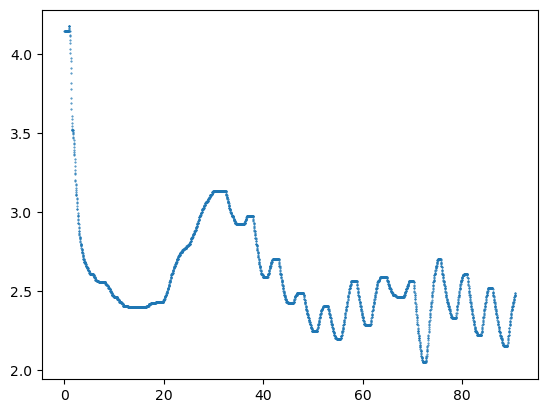

In [21]:
print(part_after_split[1])
plt.scatter(part_after_split[2].D1_time[1], part_after_split[2].D1_rating[1], s = 0.2)

## interpolate and downsample

In [13]:
def downsample(rating, time,samplingrate):
    rating_downsample_list = []
    time_downsample_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            original_timing = time[i]
            original_rating = rating[i]
            flinear = interpolate.interp1d(original_timing, original_rating)
            new_timing = np.arange(round_up(original_timing[0],1),round_down(original_timing[-1],1),1/samplingrate)
            ylinear = flinear(new_timing)
            rating_downsample_list.append(ylinear)
            time_downsample_list.append(new_timing)
        else:
            rating_downsample_list.append([np.nan])
            time_downsample_list.append([np.nan])
    return rating_downsample_list, time_downsample_list
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [23]:
downsample_rate=40
part_downsample_list=[]
for part in part_after_split:
    partcipant=pain_monitering_D1D2(part.PID)
    partcipant.update_prediction_confidence_D1(part.D1_prediction,part.D1_confidence)
    partcipant.update_prediction_confidence_D2(part.D2_prediction,part.D2_confidence)
    D1_dsmp_rating,D1_dsmp_time=downsample(part.D1_rating,part.D1_time,downsample_rate)
    D2_dsmp_rating,D2_dsmp_time=downsample(part.D2_rating,part.D2_time,downsample_rate)
    for rate_i, rating in enumerate(D1_dsmp_rating):
        partcipant.insert_rating_time_D1(rating,D1_dsmp_time[rate_i])
    for rate_i, rating in enumerate(D2_dsmp_rating):
        partcipant.insert_rating_time_D2(rating,D2_dsmp_time[rate_i])
    part_downsample_list.append(partcipant)

participant: 611babe081137b57fb423693
Day 1 rating: 3 sessions
Day 1 timing: 3 sessions
Day 1 prediction: 6.83344713
Day 1 confidence: 5.71584756
Day 2 rating: 4 sessions
Day 2 timing: 4 sessions
Day 2 prediction: 7.863067689999999
Day 2 confidence: 6.522803000000001



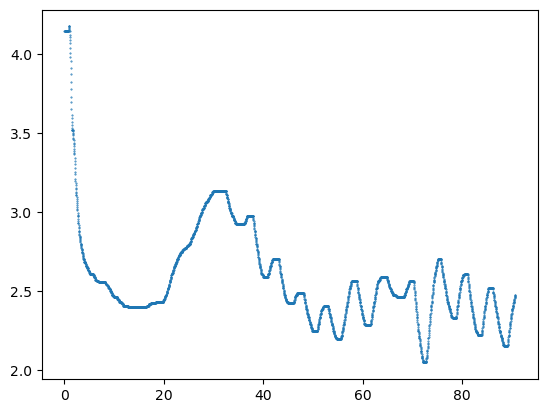

In [24]:
print(part_downsample_list[6])
plt.scatter(part_downsample_list[2].D1_time[1], part_downsample_list[2].D1_rating[1], s = 0.2)

In [25]:
PID_list=[]
D1_rating_list=[]
D1_time_list=[]
D2_rating_list=[]
D2_time_list=[]
D1_prediction_list=[]
D1_confidence_list=[]
D2_prediction_list=[]
D2_confidence_list=[]
for part in part_downsample_list:
    PID_list.append(part.PID)
    D1_rating_list.append(part.D1_rating)
    D1_time_list.append(part.D1_time)
    D2_rating_list.append(part.D2_rating)
    D2_time_list.append(part.D2_time)
    D1_prediction_list.append(part.D1_prediction)
    D1_confidence_list.append(part.D1_confidence)
    D2_prediction_list.append(part.D2_prediction)
    D2_confidence_list.append(part.D2_confidence)
df_D1D2 = pd.DataFrame({'PID': PID_list,
                   'D1_rating': D1_rating_list,
                   'D1_time': D1_time_list,
                   'D1_prediction': D1_prediction_list,
                   'D1_confidence': D1_confidence_list,
                   'D2_rating': D2_rating_list,
                   'D2_time': D2_time_list,
                   'D2_prediction': D2_prediction_list,
                   'D2_confidence': D2_confidence_list})
df_D1D2.to_pickle("../data/dataset/D1D2_downsampledata_12062023.pkl")